In [1]:
import numpy as np

def gaussQuadStd1d(g, noOfIntegPt):
    """Computes the integral ∫ g(ξ) dξ using Gaussian quadrature on [-1,1]"""
    if noOfIntegPt == 2:
        points = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])
        weights = np.array([1, 1])
    elif noOfIntegPt == 3:
        points = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)])
        weights = np.array([5/9, 8/9, 5/9])
    else:
        return 0
    
    return sum(w * g(xi) for w, xi in zip(weights, points))

def gaussQuad1d(fn, lowerLimit, upperLimit, noOfIntegPt):
    transform = lambda ξ: (upperLimit - lowerLimit) / 2 * ξ + (upperLimit + lowerLimit) / 2
    g = lambda ξ: fn(transform(ξ)) * (upperLimit - lowerLimit) / 2 

    return gaussQuadStd1d(g, noOfIntegPt)

def shapeFn1d(i, x, x1, x2, p):
    
    if x < x1 or x > x2:
        return 0  
    
    if p == 1:  
        if i == 1:
            return (x2 - x) / (x2 - x1)
        elif i == 2:
            return (x - x1) / (x2 - x1)
    
    elif p == 2: 
        mid = (x1 + x2) / 2  
        
        if i == 1:
            return (x - mid) * (x - x2) / ((x1 - mid) * (x1 - x2))
        elif i == 2:
            return (x - x1) * (x - x2) / ((mid - x1) * (mid - x2))
        elif i == 3:
            return (x - x1) * (x - mid) / ((x2 - x1) * (x2 - mid))
    
    return 0  


def shapeFnDer1d(i, x, x1, x2, p):
    
    if x < x1 or x > x2:
        return 0  
    
    if p == 1:  
        if i == 1:
            return -1 / (x2 - x1)
        elif i == 2:
            return 1 / (x2 - x1)
    
    elif p == 2:  
        mid = (x1 + x2) / 2  
        
        if i == 1:
            return ((2*x - x2 - mid) / ((x1 - mid) * (x1 - x2)))
        elif i == 2:
            return ((2*x - x1 - x2) / ((mid - x1) * (mid - x2)))
        elif i == 3:
            return ((2*x - x1 - mid) / ((x2 - x1) * (x2 - mid)))
    
    return 0
def meij(e, i, j, xh, shapeFn, noOfIntegPt):
    """Computes the mass matrix entry M^e_ij."""
    x1, x2 = xh[e-1], xh[e]
    
    def integrand(x):
        return shapeFn1d(i, x, x1, x2, shapeFn) * shapeFn1d(j, x, x1, x2, shapeFn)

    return gaussQuad1d(integrand, x1, x2, noOfIntegPt)

def keij(a, c, e, i, j, xh, shapeFn, noOfIntegPt):
    """Computes the stiffness matrix entry K^e_ij."""
    x1, x2 = xh[e-1], xh[e]

    def integrand(x):
        dphi_i = shapeFnDer1d(i, x, x1, x2, shapeFn)
        dphi_j = shapeFnDer1d(j, x, x1, x2, shapeFn)
        phi_i = shapeFn1d(i, x, x1, x2, shapeFn)
        phi_j = shapeFn1d(j, x, x1, x2, shapeFn)

        return (a(x) * dphi_i * dphi_j + c(x) * phi_i * phi_j)

    return gaussQuad1d(integrand, x1, x2, noOfIntegPt)

def fei(a, c, f, p0, e, i, xh, shapeFn, noOfIntegPt, t):
    """Computes the load vector entry F^e_i."""
    x1, x2 = xh[e-1], xh[e]

    def integrand(x):
        phi_i = shapeFn1d(i, x, x1, x2, shapeFn)
        dphi_i = shapeFnDer1d(i, x, x1, x2, shapeFn)
        G = p0*shapeFn1d(1,x,xh[0],xh[1],shapeFn)
        Gx = p0*shapeFnDer1d(1,x,xh[0],xh[1],shapeFn)
        return (f(x,t) * shapeFn1d(i, x, x1, x2, shapeFn) - a(x)*Gx*dphi_i - c(x)*G*phi_i)
        
    return gaussQuad1d(integrand, x1, x2, noOfIntegPt)

In [2]:
import numpy as np
import scipy.sparse as sp

def massM(xh, shapeFn, noOfIntegPt):
    
    n_elem = len(xh) - 1  # Number of elements
    n_nodes = n_elem * shapeFn  # Total nodes based on shape function order
    
    # Initialize sparse matrix
    M = sp.lil_matrix((n_nodes, n_nodes))
    
    # Loop over each element
    for e in range(1, n_elem + 1):
        x1, x2 = xh[e-1], xh[e]  # Element endpoints
        
        # Local mass matrix for element e
        local_M = np.zeros((shapeFn + 1, shapeFn + 1))
        
        for i in range(1, shapeFn + 2):
            for j in range(1, shapeFn + 2):
                local_M[i-1, j-1] = meij(e, i, j, xh, shapeFn, noOfIntegPt)
        
        # Assemble into global matrix
        if shapeFn == 1:
            if e == 1:
                M[0,0] = local_M[-1,-1]
            else:
                for i in range(shapeFn + 1):
                    for j in range(shapeFn + 1):
                        global_i = e - 2 + i
                        global_j = e - 2 + j
                        M[global_i, global_j] += local_M[i, j]
        else:
            if e == 1:
                for i in range(1,3):
                    for j in range(1,3):
                        M[i-1,j-1] = local_M[i,j]
            else:
                for i in range(shapeFn + 1):
                    for j in range(shapeFn + 1):
                        global_i = 2*e - 3 + i        
                        global_j = 2*e - 3 + j
                        M[global_i, global_j] += local_M[i,j]
    
    return M.tocsr()  # Convert to CSR format for efficiency


In [3]:
import numpy as np
import scipy.sparse as sp

def stiffK(a, c, xh, shapeFn, noOfIntegPt):
    
    n_elem = len(xh) - 1  # Number of elements
    n_nodes = n_elem * shapeFn  # Total nodes based on shape function order

    # Initialize sparse matrix
    K = sp.lil_matrix((n_nodes, n_nodes))

    # Loop over each element
    for e in range(1, n_elem + 1):
        x1, x2 = xh[e-1], xh[e]  # Element endpoints
        
        # Local stiffness matrix for element e
        local_K = np.zeros((shapeFn + 1, shapeFn + 1))
        
        for i in range(1, shapeFn + 2):
            for j in range(1, shapeFn + 2):
                local_K[i-1, j-1] = keij(a, c, e, i, j, xh, shapeFn, noOfIntegPt)

        # Assemble into global matrix
        if shapeFn == 1:
            if e == 1:
                K[0,0] = local_K[-1,-1]
            else:
                for i in range(shapeFn + 1):
                    for j in range(shapeFn + 1):
                        global_i = e - 2 + i
                        global_j = e - 2 + j
                        K[global_i, global_j] += local_K[i, j]
        else:
            if e == 1:
                for i in range(1,3):
                    for j in range(1,3):
                        K[i-1,j-1] = local_K[i,j]
            else:
                for i in range(shapeFn + 1):
                    for j in range(shapeFn + 1):
                        global_i = 2*e - 3 + i        
                        global_j = 2*e - 3 + j
                        K[global_i, global_j] += local_K[i,j]

    return K.tocsr()  # Convert to CSR format for efficient calculations


In [4]:
import numpy as np

def loadF(a, c, f, p0, QL, xh, shapeFn, noOfIntegPt):
    
    n_elem = len(xh) - 1  # Number of elements
    n_nodes = n_elem * shapeFn  # Total nodes based on shape function order
    
    def F_func(t):
        # Initialize global load vector
        F = np.zeros(n_nodes)

        # Loop over elements
        for e in range(1, n_elem + 1):
            x1, x2 = xh[e-1], xh[e]  # Element endpoints

            # Local load vector
            local_F = np.zeros(shapeFn + 1)

            for i in range(1, shapeFn + 2):
                local_F[i-1] = fei(a, c, f, p0, e, i, xh, shapeFn, noOfIntegPt, t)

            # Assemble local contributions into global load vector
            if shapeFn == 1:
                if e == 1:
                    F[0] = local_F[-1]
                else:
                    for i in range(shapeFn + 1):
                        global_i = e - 2 + i
                        F[global_i] += local_F[i]
            else:
                if e == 1:
                    for i in range (1,2):
                        F[i-1] = local_F[i]
                else:
                    for i in range(shapeFn + 1):
                        global_i = 2*e - 3 + i
                        F[global_i] += local_F[i]

        # Apply Neumann boundary condition at x = L
        F[-1] += QL(t)

        return F
    return F_func
    


In [5]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

def crank_nicolson_solver(M, K, F_func, u0_func, xh, T, dt, QL, p0, shapeFn):
    """
    Solves MW' + KW = F using Crank–Nicolson time-stepping.
    
    Parameters:
    - M: Mass matrix (sparse or dense)
    - K: Stiffness matrix (sparse or dense)
    - F_func: function f(x, t) returning the load vector at time t
    - u0_func: function u0(x) for initial condition
    - xh: node coordinates
    - T: final time
    - dt: time step size
    - QL: Neumann boundary value function QL(t)
    - p0: Dirichlet value at x=0

    Returns:
    - uh_list: list of functions uh(x) representing solution at each time step
    """
    def uh_func(W):
        def uh(x):
            x = np.atleast_1d(x)
            vals = np.zeros_like(x)
            for i, xi in enumerate(x):
                for e in range(n_elem):
                    if xh[e] <= xi <= xh[e + 1]:
                        x1, x2 = xh[e], xh[e + 1]
                        phi1 = (x2 - xi) / (x2 - x1)
                        phi2 = (xi - x1) / (x2 - x1)
                        vals[i] = W[e] * phi1 + W[e + 1] * phi2
                        break
            return vals if len(vals) > 1 else vals[0]

        return uh
    
    n_elem = len(xh) - 1
    time_steps = int(T / dt)
    uh_list = []

    # Reconstruct global node coordinates to evaluate u0 properly
    if shapeFn == 1:
        # Linear — just linearly spaced nodes
        x_nodes = np.array(xh[0:-1])
    elif shapeFn == 2:
        # Quadratic — midpoints in addition to endpoints
        x_nodes = []
        for i in range(len(xh) - 1):
            x1, x2 = xh[i], xh[i+1]
            x_nodes.extend([x1, (x1 + x2)/2])
        #x_nodes.append(xh[-1])  # last node
        x_nodes = np.array(x_nodes)
        #print(x_nodes)
    else:
        raise ValueError("Unsupported shape function order.")

    # Initial condition vector
    Wn = np.array([u0_func(x) for x in x_nodes])

    # Crank–Nicolson matrices
    A = M + 0.5 * dt * K
    B = M - 0.5 * dt * K
    
    # Store initial condition
    uh_list.append(uh_func(Wn))

    # Time stepping
    for n in range(time_steps):
        t_n = n * dt
        t_np1 = (n + 1) * dt

        Fn = F_func(t_n)
        Fnp1 = F_func(t_np1)
        F_mid = 0.5 * dt * (Fn + Fnp1)

        rhs = B @ Wn + F_mid

        # Apply Dirichlet boundary condition at x=0
        rhs[0] = p0
        A_bc = A.copy()
        A_bc = A_bc.tolil()
        A_bc[0, :] = 0
        A_bc[0, 0] = 1

        # Apply Neumann condition at x=L
        rhs[-1] += QL(t_np1) * dt / 2

        # Solve linear system
        Wnp1 = spsolve(A_bc.tocsr(), rhs)

        uh_list.append(uh_func(Wnp1))

        # Prepare for next step
        Wn = Wnp1

    return uh_list


In [ ]:
# This file contains functions that assemble calculated node values
# from a 1D FEM menthod to approximated solution
#
#
# Last update: Chung-min Lee March 15, 2025
import numpy as np
!!!!! NOTE THAT YOU NEED TO IMPORT SHAPEFNS !!!!
##--------------------------------------------------
# assemble solution on the nodes and give the solution function
##--------------------------------------------------
def approxSol(w: np.array, p0: float, xh: np.array, shapeFn:int):
'''
This function takes the solution of the values of the nodes and gives the
approximated solution on the interval [0,L]
[uh] = approxSol(w, u0, xh, shapeFn)
where
w is the values of the nodes excluding the node value at x=0,
p0 is the Dirichlet BC at x = 0,
xh = [x_1,x_2,...,x_{n+1}] is the list of endpoints of all elements,
shapeFn indicates the choice of linear (use 1) or quadratic (use 2) shape
functions
'''
w = np.hstack((p0, w))
if (shapeFn == 1): # if linear shape functions are used
uh = lambda x: linearApprox(x,w,xh)
else: # if quadratic shape functions are used
uh = lambda x: quadraticApprox(x,w,xh)
return uh
##--------------------------------------------------
# assemble linear shape functions on the whole domain
##-------------------------------------------------
def linearApprox(x: np.array, v: np.array,xh: np.array):
if (np.ndim(x) == 0):
#print('x is a scalar')
x = np.array([x])
# declare the output array
y = np.zeros(len(x))
# mesh size
h = xh[1]-xh[0]
# determine which subinterval x belongs to
ind = np.floor(x/h).astype(int)
x1 = h * ind
x2 = x1 + h
ind = ind+1# This file contains functions that assemble calculated node values
# from a 1D FEM menthod to approximated solution
#
#
# Last update: Chung-min Lee March 15, 2025
import numpy as np
!!!!! NOTE THAT YOU NEED TO IMPORT SHAPEFNS !!!!
##--------------------------------------------------
# assemble solution on the nodes and give the solution function
##--------------------------------------------------
def approxSol(w: np.array, p0: float, xh: np.array, shapeFn:int):
'''
This function takes the solution of the values of the nodes and gives the
approximated solution on the interval [0,L]
[uh] = approxSol(w, u0, xh, shapeFn)
where
w is the values of the nodes excluding the node value at x=0,
p0 is the Dirichlet BC at x = 0,
xh = [x_1,x_2,...,x_{n+1}] is the list of endpoints of all elements,
shapeFn indicates the choice of linear (use 1) or quadratic (use 2) shape
functions
'''
w = np.hstack((p0, w))
if (shapeFn == 1): # if linear shape functions are used
uh = lambda x: linearApprox(x,w,xh)
else: # if quadratic shape functions are used
uh = lambda x: quadraticApprox(x,w,xh)
return uh
##--------------------------------------------------
# assemble linear shape functions on the whole domain
##-------------------------------------------------
def linearApprox(x: np.array, v: np.array,xh: np.array):
if (np.ndim(x) == 0):
#print('x is a scalar')
x = np.array([x])
# declare the output array
y = np.zeros(len(x))
# mesh size
h = xh[1]-xh[0]
# determine which subinterval x belongs to
ind = np.floor(x/h).astype(int)
x1 = h * ind
x2 = x1 + h
ind = ind+1
# the right end point x=L
indLastPt = np.where(ind == len(v))[0]
y[indLastPt] = v[-1]
indNotLastPt = np.where(ind < len(v))[0]
y[indNotLastPt] = v[ind[indNotLastPt]-1] *
shapeFn1d(1,x[indNotLastPt],x1[indNotLastPt],x2[indNotLastPt],1) + \
v[ind[indNotLastPt]] *
shapeFn1d(2,x[indNotLastPt],x1[indNotLastPt],x2[indNotLastPt],1)
return y
##--------------------------------------------------
# assemble quadratic shape functions on the whole domain
##-------------------------------------------------
def quadraticApprox(x: np.array,v: np.array,xh: np.array):
if (np.ndim(x) == 0):
#print('x is a scalar')
x = np.array([x])
# declare the output array
y = np.zeros(len(x))
# mesh size
h = xh[1]-xh[0]
# determine which subinterval x belongs to
ind = np.floor(x/h).astype(int)
x1 = ind*h
x2 = x1+h
ind = ind+1
# the right end point x=L
indLastPt = np.where(ind == (len(v)+1)/2)[0]
y[indLastPt] = v[-1]
indNotLastPt = np.where(ind < (len(v)+1)/2)[0]
y[indNotLastPt] = v[2*ind[indNotLastPt]-2] *
shapeFn1d(1,x[indNotLastPt],x1[indNotLastPt],x2[indNotLastPt],2)\
+ v[2*ind[indNotLastPt]-1] *
shapeFn1d(2,x[indNotLastPt],x1[indNotLastPt],x2[indNotLastPt],2) \
+ v[2*ind[indNotLastPt]] *
shapeFn1d(3,x[indNotLastPt],x1[indNotLastPt],x2[indNotLastPt],2)
return y


In [6]:
def myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle, shapeFn):
    xh = np.linspace(0, L, noOfEle + 1)
    M = massM(xh, shapeFn, 3)
    K = stiffK(a, c, xh, shapeFn, 3)
    Ft = loadF(a, c, f, p0, QL, xh, shapeFn, 3)
    uh = crank_nicolson_solver(M, K, Ft, u0, xh, T, dt, QL, p0, shapeFn)
    
    return uh

In [7]:
#Test case 1
import numpy as np
a = lambda x: 4-x
c = lambda x: 1*x
f = lambda x,t:-2*t*np.sin(x)/((1+t**2)**2) + (np.cos(x)+4*np.sin(x))/(1+t**2)
L = 2.
T = 1.
p0 = 0.
QL = lambda t: 2*np.cos(2)/(1+t**2)
u0 = lambda x: np.sin(x)
dt = 0.1
shapeFn = 1
noOfEle = 4
uh = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle, shapeFn)
np.set_printoptions(precision=4)
#print(f'W = {W}')
print(f'uh(x) = {uh[-1] (np.array([0.2, 1.37, 0.15, 2.22]))}') 

uh(x) = [0.0706 0.1952 0.053  0.    ]


In [8]:
#Test case 2
shapeFn = 2
uh = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle, shapeFn)
np.set_printoptions(precision=4)
#print(f'W = {W}')
print(f'uh(x) = {uh[5](np.array([1.2, 0, 2.15, 0.49]))}')

uh(x) = [0.372  0.     0.     0.1393]


In [9]:
#Project 1 problem
import numpy as np
a = lambda x: 2 + x
c = lambda x: 1*x
f = lambda x,t:(2 + 2*t - 4*x*t - 4*x**2*t)*np.cos(x) + (1 - 8*t - 6*x*t)*np.sin(x)
L = np.pi
T = 1.
p0 = 1.
QL = lambda t: 2*t*(np.pi + 2)
u0 = lambda x: np.cos(x)
dt = 0.01
shapeFn1 = 1
shapeFn2 = 2
noOfEle1 = 16
noOfEle2 = 32
noOfEle3 = 64
noOfEle4 = 128

true_soln = lambda x,t: (1-2*x*t)*np.cos(x)

lin_uh16 = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle1, shapeFn1)
lin_uh32 = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle2, shapeFn1)
lin_uh64 = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle3, shapeFn1)
lin_uh128 = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle4, shapeFn1)

quad_uh16 = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle1, shapeFn2)
quad_uh32 = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle2, shapeFn2)
quad_uh64 = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle3, shapeFn2)
quad_uh128 = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle4, shapeFn2)

x_vals = np.linspace(0, L, 100)
np.set_printoptions(precision=4)

IndexError: index 16 is out of bounds for axis 0 with size 16

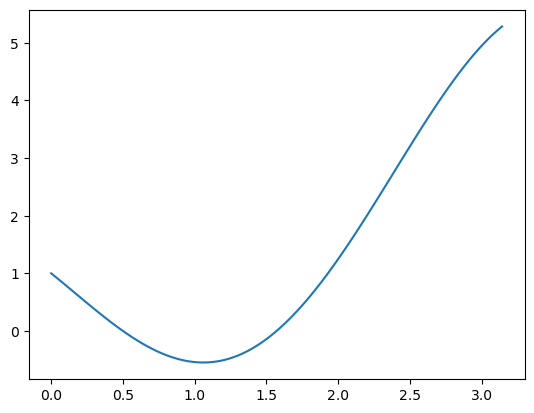

In [10]:
import matplotlib.pyplot as plt

plt.plot(x_vals, true_soln(x_vals,1), label='true solution')
plt.plot(x_vals, lin_uh16[-1](x_vals), label='16 elements')
plt.plot(x_vals, lin_uh32[-1](x_vals), label='32 elements')
plt.plot(x_vals, lin_uh64[-1](x_vals), label='64 elements')
plt.plot(x_vals, lin_uh128[-1](x_vals), label='128 elements')

plt.xlabel('x')
plt.ylabel('u(x, 1)')
plt.title('FEM solution at t=1 for different mesh resolutions')
plt.legend()
plt.grid(True)
plt.show()

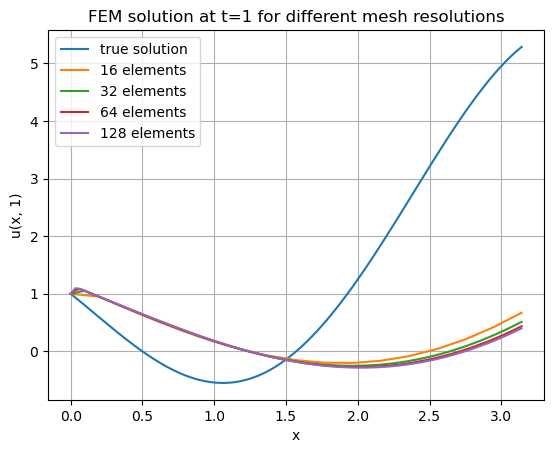

In [11]:
plt.plot(x_vals, true_soln(x_vals,1), label='true solution')
plt.plot(x_vals, quad_uh16[-1](x_vals), label='16 elements')
plt.plot(x_vals, quad_uh32[-1](x_vals), label='32 elements')
plt.plot(x_vals, quad_uh64[-1](x_vals), label='64 elements')
plt.plot(x_vals, quad_uh128[-1](x_vals), label='128 elements')

plt.xlabel('x')
plt.ylabel('u(x, 1)')
plt.title('FEM solution at t=1 for different mesh resolutions')
plt.legend()
plt.grid(True)
plt.show()

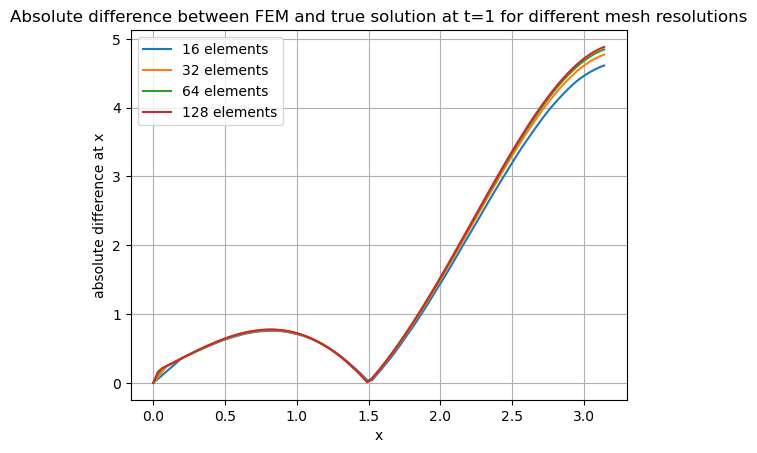

In [12]:
plt.plot(x_vals, np.abs(true_soln(x_vals,1) - quad_uh16[-1](x_vals)), label='16 elements')
plt.plot(x_vals, np.abs(true_soln(x_vals,1) - quad_uh32[-1](x_vals)), label='32 elements')
plt.plot(x_vals, np.abs(true_soln(x_vals,1) - quad_uh64[-1](x_vals)), label='64 elements')
plt.plot(x_vals, np.abs(true_soln(x_vals,1) - quad_uh128[-1](x_vals)), label='128 elements')

plt.xlabel('x')
plt.ylabel('absolute difference at x')
plt.title('Absolute difference between FEM and true solution at t=1 for different mesh resolutions')
plt.legend()
plt.grid(True)
plt.show()

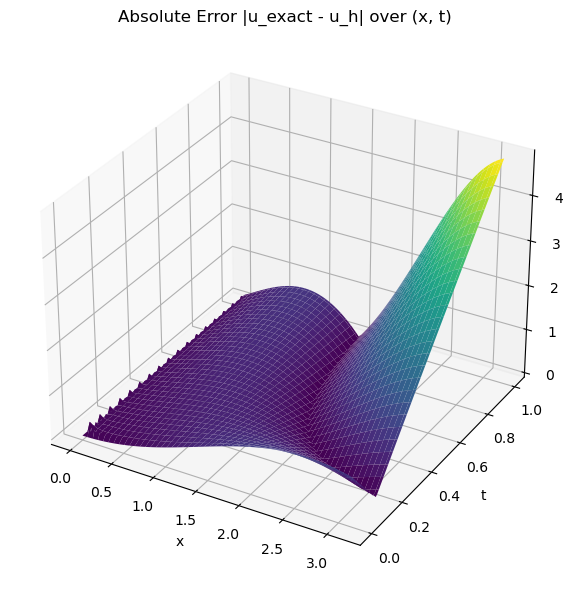

In [13]:
x_vals = np.linspace(0, L, 100)           # 100 spatial points
t_vals = np.arange(0, T + dt, dt)         # All time steps including final time
X, T_grid = np.meshgrid(x_vals, t_vals)   # For surface plotting

def u_exact(x, t):
    return (1 - 2*x*t)*np.cos(x)           # Replace this with your actual solution

# Get your computed uh from the solver
uh = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle=128, shapeFn=2)

# Allocate array to store the error
abs_error = np.zeros_like(X)

# Loop through time steps and compute absolute error
for i, t in enumerate(t_vals):
    uh_t = uh[i](x_vals)                 # FEM solution at time t
    u_true = u_exact(x_vals, t)         # Exact solution
    abs_error[i, :] = np.abs(uh_t - u_true)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T_grid, abs_error, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Absolute Error')
ax.set_title('Absolute Error |u_exact - u_h| over (x, t)')
plt.tight_layout()
plt.show()


In [14]:
A = np.array([[1, np.log(16)], [1, np.log(32)], [1, np.log(64)], [1, np.log(128)]])
b = np.array([np.linalg.norm(true_soln(x_vals,1) - quad_uh16[-1](x_vals)), np.linalg.norm(true_soln(x_vals,1) - quad_uh32[-1](x_vals)), np.linalg.norm(true_soln(x_vals,1) - quad_uh64[-1](x_vals)), np.linalg.norm(true_soln(x_vals,1) - quad_uh128[-1](x_vals))])
x, residuals, rank, s  = np.linalg.lstsq(A,b, rcond = None)
print(x)

[20.0524  0.548 ]
